In [2]:
#!/usr/bin/env python3
import sys
import cv2
import os
import numpy as np
np.float = np.float64

import matplotlib.pyplot as plt
#from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from math import ceil
from sensor_msgs.msg import Image,LaserScan,PointCloud2

from cv_bridge import CvBridge
import rospy
import ros_numpy

from utils.misc_utils import RGBD


In [3]:
try:
    # ruta absoluta
    usr_url=os.path.expanduser( '~' )
    sys.path.append(usr_url+'/openpose/build/python');
    from openpose import pyopenpose as op
except ImportError as e:
    print('Error: OpenPose library could not be found. Did you enable `BUILD_PYTHON` in CMake and have this Python script in the right folder?')
    raise e


In [4]:
def detect_drinking(data):
    """
        Brazo derecho: 2,3,4 (hombro,codo,mano) 
        Brazo izquierdo: 5,6,7 (hombro,codo,mano)
    """
    ang_max=115
    cos_A=np.dot((data[2,:]-data[3,:]),(data[4,:]-data[3,:]))/(np.linalg.norm((data[2,:]-data[3,:]))*np.linalg.norm((data[4,:]-data[3,:])))
    #print(cos_A)
    cos_B=np.dot((data[5,:]-data[6,:]),(data[7,:]-data[6,:]))/(np.linalg.norm((data[5,:]-data[6,:]))*np.linalg.norm((data[7,:]-data[6,:])))
    #print(cos_B)
    ang_der=np.rad2deg(np.arccos(cos_A))
    ang_izq=np.rad2deg(np.arccos(cos_B))
    
    if abs(ang_der)<=ang_max or abs(ang_izq)<=ang_max:
        #print("Se detecta que tiene una bebida")
        return True
    else:
        #print("No se detecta brazo con bebida")
        return False

#---------------------------------------------------
# Para escribir texto en imagen con fondo negro
def draw_text_bkgn(img, text,
          font=cv2.FONT_HERSHEY_PLAIN,
          pos=(0, 0),
          font_scale=1,
          font_thickness=2,
          text_color=(0, 255, 0),
          text_color_bg=(0, 0, 0)
          ):

    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, pos, (x + text_w, y + text_h), text_color_bg, -1)
    cv2.putText(img, text, (x, y + text_h + int(font_scale) - 1), font, font_scale, text_color, font_thickness)

    return text_size

#---------------------------------------------------
def init_openPose(n_people=-1,net_res="-1x208",model="BODY_25"):
    try:
        usr_url=os.path.expanduser( '~/' )
        params = dict()

        params["model_folder"] = usr_url+"openpose/models/"
        params["model_pose"] = model
        params["net_resolution"]= net_res
        # -1 -> toda persona detectable
        params["number_people_max"]= n_people

        opWrapper = op.WrapperPython()
        opWrapper.configure(params)
        opWrapper.start()
        datum = op.Datum()

    except Exception as e:
        print("exception:",e)
        sys.exit(-1)
    return opWrapper,datum
    
#---------------------------------------------------
def draw_skeleton(joints,hh,wh,im,cnt_person=0,norm=False,bkground=False,centroid=False):

    """
    conections 15 (of 25) joints:
        0-1   <-> centro cabeza         - cuello-torso
        0-11  <-> centro cabeza         - ojo D ?
        0-12  <-> centro cabeza         - ojo I ?
        1-2   <-> cuello-torso          - hombro D
        1-5   <-> cuello-torso          - hombro I
        1-8   <-> cuello-torso          - tronco-cadera ombligo
        2-3   <-> hombro D              - codo D
        3-4   <-> codo D                - muñeca D
        5-6   <-> hombro I              - codo I
        6-7   <-> codo I                - muñeca I
        8-9   <-> tronco-cadera ombligo - tronco-cadera D 
        8-10  <-> tronco-cadera ombligo -tronco-cadera I 
        11-13 <-> ojo D ?               - oreja D
        12-14 <-> ojo I ?               - oreja I

    conections 14 (of 18) joints:

        0-1  <-> centro cabeza  - cuello-torso
        0-10 <-> centro cabeza  - ojo D
        0-11 <-> centro cabeza  - ojo I
        1-2  <-> cuello-torso   - hombro D
        1-5  <-> cuello-torso   - hombro I
        1-8  <-> cuello-torso   - tronco-cadera D
        1-9  <-> cuello-torso   - tronco-cadera I
        2-3  <-> hombro D       - codo D
        3-4  <-> codo D         - muneca D
        5-6  <-> hombro I       - codo I
        6-7  <-> codo I         - muneca I
        10-12<-> ojo D          - oreja D
        11-13<-> ojo I          - oreja I
 

    """
    h=1
    w=1
    lineThick=2
    circleSize=3

    if norm:
        h=hh
        w=wh

    if bkground:
        bkgn=im.astype(np.uint8)
    else:
        bkgn=np.zeros((hh,wh,3),np.uint8)
    
    if centroid:
        lnCnt=int(joints.shape[0]/2)
        frame=np.zeros((lnCnt,2))
        frame[:,0]=joints[:lnCnt]
        frame[:,1]=joints[lnCnt:]
        if frame.shape[0]==15:
            conections=[[0,1],[0,11],[0,12],[1,2],[1,5],[1,8],
                [2,3],[3,4],[5,6],[6,7],[8,9],[8,10],
                [11,13],[12,14]]
        else:
            conections=[[0,1],[0,14],[0,15],[1,2],[1,5],[1,8],
                [1,11],[2,3],[3,4],[5,6],[6,7],[8,9],
                [9,10],[11,12],[12,13],[14,16],[15,17]]

        
        for conect in conections:
            if frame[conect[0]][0]!=0 and frame[conect[1]][1]!=0:
                bkgn=cv2.line(bkgn,(int(frame[conect[0]][0]*h),int(frame[conect[0]][1]*w)),(int(frame[conect[1]][0]*h),int(frame[conect[1]][1]*w)),(0,255,255),lineThick)
        for i in range(frame.shape[0]):
                    if frame[i][0]!=0.0 and frame[i][1]!=0.0:
                        bkgn=cv2.circle(bkgn,(int(frame[i][0]*h),int(frame[i][1]*w)),circleSize,(190,152,253),-1)

        return bkgn

    else:

        if joints.shape[0]==15:
            conections=[[0,1,0],[0,11,1],[0,12,2],[1,2,3],[1,5,4],[1,8,5],
                        [2,3,6],[3,4,7],[5,6,8],[6,7,9],[8,9,10],[8,10,11],
                        [11,13,12],[12,14,13]]
            # 0-1|0-11|0-12|1-2|1-5|1-8
            # 2-3|3-4|5-6|6-7|8-9|8-10 
            # 11-13|12-14
            colors=[(41,23,255),(99,1,249),(251,10,255),(10,75,255),(41,243,186),(10,10,255),   
                    (25,136,253),(40,203,253),(0,218,143),(0,218,116),(78,218,0),(253,183,31),   
                    (248,8,207),(248,8,76)]            

        elif joints.shape[0]==18:
            conections=[[0,1,0],[0,14,1],[0,15,2],[1,2,3],[1,5,4],[1,8,5],
                        [1,11,5],[2,3,6],[3,4,7],[5,6,8],[6,7,9],[8,9,10],
                        [9,10,11],[11,12,12],[12,13,13],[14,16,1],[15,17,1]]
            colors=[(253,45,31),(253,31,104),(253,31,184),(3,14,250),(15,104,252),(72,219,0),
                    (192,219,0),(18,170,255),(50,220,255),(50,255,152),(50,255,82),(113,219,0),
                    (167,251,77),(219,171,0),(219,113,0),(253,31,159),(159,31,253)]

        elif joints.shape[0]==25:
            conections=[[0,1,0],[0,15,1],[0,16,2],[1,2,3],[1,5,4],[1,8,5],
                        [2,3,6],[3,4,7],[5,6,8],[6,7,9],[8,9,10],[8,12,11],
                        [9,10,12],[10,11,13],[11,22,13],[11,24,13],[12,13,14],[13,14,15],
                        [14,19,15],[14,21,15],[15,17,16],[16,18,17],[19,20,15],[22,23,13]]
            # 0-1|0-15|0-16|1-2|1-5|1-8
            # 2-3|3-4|5-6|6-7|8-9|8-12 
            # 9-10|<10-11|11-22|11-24|22-23>|12-13|<13-14|14-19|14-21|19-20>|15-17|16-18
            colors=[(41,23,255),(99,1,249),(251,10,255),(10,75,255),(41,243,186),(10,10,255),
                    (25,136,253),(40,203,253),(0,218,143),(0,218,116),(78,218,0),(253,183,31),
                    (148,241,4),(239,255,1),(253,145,31),(253,80,31),(248,8,207),(248,8,76)]

        else:  #18 to less joints
            conections=[[0,1,0],[0,10,1],[0,11,2],[1,2,3],[1,5,4],[1,8,5],
                        [1,9,5],[2,3,6],[3,4,7],[5,6,8],[6,7,9],
                        [10,12,1],[11,13,1]]

            colors=[(253,45,31),(253,31,104),(253,31,184),(3,14,250),(15,104,252),(72,219,0),
                    (192,219,0),(18,170,255),(50,220,255),(50,255,152),(50,255,82),(113,219,0),
                    (167,251,77),(219,171,0),(219,113,0),(253,31,159),(159,31,253)]

        for i in range(joints.shape[0]):
            if joints[i][0]!=0.0 and joints[i][1]!=0.0:
                bkgn=cv2.circle(bkgn,(int(joints[i][0]*h),int(joints[i][1]*w)),circleSize,(255,255,255),-1)

        for conect in conections:
            if joints[conect[0]][0]!=0 and joints[conect[1]][1]!=0:
                bkgn=cv2.line(bkgn,(int(joints[conect[0]][0]*h),int(joints[conect[0]][1]*w)),(int(joints[conect[1]][0]*h),int(joints[conect[1]][1]*w)),colors[conect[2]],lineThick)
        
        draw_text_bkgn(bkgn,text="Person:"+str(cnt_person),pos=(int(joints[0,0]), int(joints[0,1])-40),
                   font_scale=1.3,text_color=(255, 255, 32))
        return bkgn
#---------------------------------------------------

In [7]:
bridge = CvBridge()
rospy.init_node('pruebas_de_graspeo')
rgbd=RGBD()

In [5]:
opWrapper,datum=init_openPose()

Starting OpenPose Python Wrapper...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.


(480, 640, 3) <class 'numpy.ndarray'>


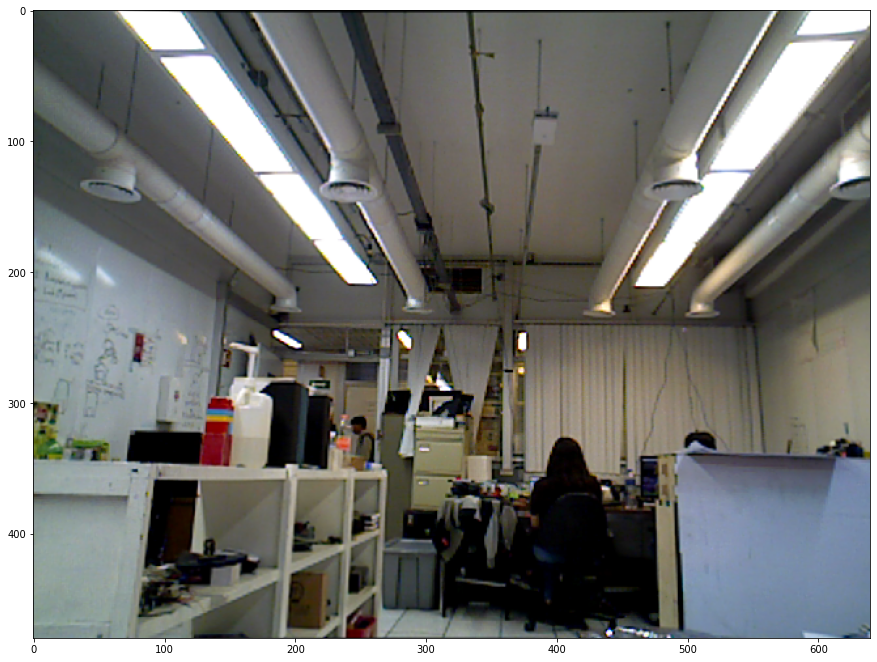

In [19]:
#image2=rgbd.get_image()
data=rospy.wait_for_message("/hsrb/head_rgbd_sensor/depth_registered/rectified_points",PointCloud2)
# NO SE CORRIGE ( -> correct_points() ), SE OBSERVO QUE NO FUE NECESARIO
np_data=ros_numpy.numpify(data)
image2=cv2.cvtColor(np_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]], cv2.COLOR_BGR2RGB)
print(image2.shape,type(image2))
h,w,_=image2.shape
image2=cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

fig=plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(image2)

In [20]:
datum.cvInputData = image2
opWrapper.emplaceAndPop(op.VectorDatum([datum]))
if datum.poseKeypoints is not None:
    print(datum.poseKeypoints.shape)
    dataout=np.copy(datum.poseKeypoints[:,:,:2])
else:
    print("No pose detected")

(2, 25, 3)


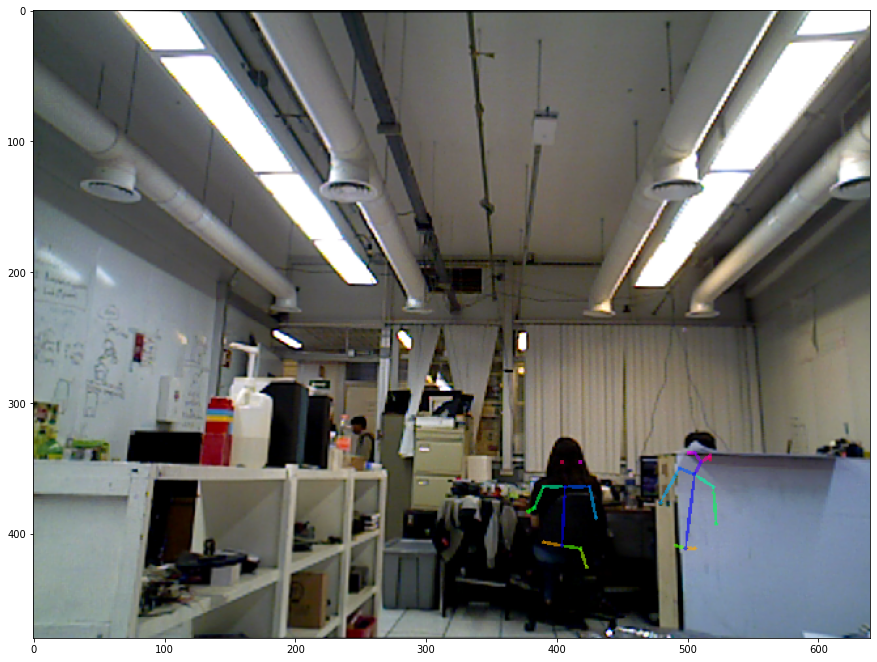

In [21]:

fig=plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(datum.cvOutputData)

In [51]:
for sk in dataout:
    print(sk)
    print("")

[[290.694   250.57823]
 [309.54584 253.0834 ]
 [293.0359  255.30391]
 [290.76224 285.9778 ]
 [288.36746 295.465  ]
 [319.0744  253.02715]
 [347.39835 255.38217]
 [344.94632 262.45157]
 [309.52252 302.52203]
 [293.2253  300.15442]
 [252.84798 311.87762]
 [255.36005 349.76276]
 [316.6463  304.88742]
 [281.28326 321.3803 ]
 [271.8925  363.8647 ]
 [290.6682  243.5294 ]
 [292.99667 241.22787]
 [  0.        0.     ]
 [302.55905 238.80707]
 [255.34995 368.5701 ]
 [260.08905 368.66592]
 [271.88876 366.1641 ]
 [245.89989 359.17667]
 [245.89844 359.12292]
 [257.66995 352.12805]]

[[ 75.963806  85.53153 ]
 [ 97.22898   99.559875]
 [ 83.00581   99.64262 ]
 [ 80.76055  104.35768 ]
 [  0.         0.      ]
 [109.05346   99.54059 ]
 [130.28047   99.63797 ]
 [104.282555  83.17363 ]
 [ 87.879585 144.39636 ]
 [ 83.01077  142.1386  ]
 [ 35.864563 151.52127 ]
 [ 66.60848  189.24727 ]
 [101.93231  144.50667 ]
 [ 59.462227 158.62474 ]
 [ 80.72672  194.02608 ]
 [ 78.351364  83.10577 ]
 [ 80.66475   83.1279  

In [50]:
print(dataout.shape)
for i in range(dataout.shape[0]):
    frame=draw_skeleton(dataout[i],h,w,image,cnt_person=i,bkground=True)


(7, 25, 2)


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


In [32]:
cv2.imshow("R",frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Ciclo

In [74]:
conteo_sin_bebida=0
#for i in range(1000):
while(True):    
    """
    # PARA USB_CAM}
    
    data = rospy.wait_for_message("/usb_cam/image_raw",Image) 
    cv2_img = bridge.imgmsg_to_cv2(data)#, "bgr8")
    #rospy.sleep(0.3)
    image=np.copy(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))
    #print(image.shape)
    h,w,_=image.shape
    
    """
    
    data=rospy.wait_for_message("/hsrb/head_rgbd_sensor/depth_registered/rectified_points",
        PointCloud2)
    # NO SE CORRIGE ( -> correct_points() ), SE OBSERVO QUE NO FUE NECESARIO
    np_data=ros_numpy.numpify(data)
    image=cv2.cvtColor(np_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]], cv2.COLOR_BGR2RGB)
    #image=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h,w,_=image.shape
    print("1")
    # PARA OBTENER ESQUELETO CON OPENPOSE
    datum.cvInputData = image
    opWrapper.emplaceAndPop(op.VectorDatum([datum]))
    #  Se guarda en una variable para posterior uso
    if datum.poseKeypoints is not None:
        dataout=np.copy(datum.poseKeypoints[:,:,:2])
        # se dibuja para visualizacion
        for i in range(dataout.shape[0]):
            image=draw_skeleton(dataout[i],h,w,image,cnt_person=i,bkground=True)
            
        if detect_drinking(dataout[0]):
            conteo_sin_bebida=0
            cv2.putText(img=image, text="Bebida detectada en algun brazo    Conteo:"+str(conteo_sin_bebida), 
                    org=(5, 20),fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=(35, 255, 148),thickness=2)

        else:
            cv2.putText(img=image, text="No tiene bebida    Conteo:"+str(conteo_sin_bebida), 
                    org=(5, 20),fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=(35, 255, 148),thickness=2)

            conteo_sin_bebida+=1
    
    else:
        print("NO SK")
        cv2.putText(img=image, text="No se detecta SK    Conteo:"+str(conteo_sin_bebida), 
                    org=(5, 20),fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=(35, 255, 148),thickness=2)

    # --------------------
    
    
    
    cv2.imshow("RES",image)
    cv2.waitKey(10)
    
    if conteo_sin_bebida==30:
        print("\n\nNO TIENE BEBIDA, PROCEDO A OFRECER UNA\n")
        break
cv2.destroyAllWindows()
    

1
No se detecta brazo con bebida


/tmp/ipykernel_10989/2505299710.py:7: RuntimeWarning: invalid value encountered in float_scalars
  cos_A=np.dot((data[2,:]-data[3,:]),(data[4,:]-data[3,:]))/(np.linalg.norm((data[2,:]-data[3,:]))*np.linalg.norm((data[4,:]-data[3,:])))


1
No se detecta brazo con bebida
1
No se detecta brazo con bebida
1
No se detecta brazo con bebida
1
No se detecta brazo con bebida
1
No se detecta brazo con bebida
1
No se detecta brazo con bebida
1
No se detecta brazo con bebida
1
No se detecta brazo con bebida
1
No se detecta brazo con bebida
1
No se detecta brazo con bebida
1
No se detecta brazo con bebida
1
No se detecta brazo con bebida
1
No se detecta brazo con bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una bebida
1
Se detecta que tiene una 